In [13]:
# import sklearn
# from sklearn import model_selection
import tensorflow as tf
# import torch
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential
import tensorflow.keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import cv2
import imageio
import tqdm
import PIL.Image as pil
# from torchvision import transforms
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import time
from PIL import Image
%matplotlib inline

In [14]:
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [15]:
# print(torch.cuda.get_device_name())
# print(tf.config.list_physical_devices('GPU'))

In [16]:
orig_width = 1918
orig_height = 1280

# DATA PREP

In [87]:
base_path = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation'

In [88]:
train_masks_csv = os.path.join(base_path, r'train_masks.csv\train_masks.csv')

In [89]:
try:
  df_train_mask = pd.read_csv(train_masks_csv)
except FileNotFoundError:
  print(f"{train_masks_csv} is not a valid path")

In [90]:
train_imgs = os.path.join(base_path, 'train', 'train')
train_masks = os.path.join(base_path, 'train_masks', 'train_masks')

In [91]:
df_train_mask['img_id'] = df_train_mask['img'].map(lambda s: s.split('.')[0])
df_train_mask = df_train_mask.set_index('img_id')

In [92]:
df_train_mask

,img,rle_mask
img_id,,
00087a6bd4dc_01,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
00087a6bd4dc_02,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
00087a6bd4dc_03,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
00087a6bd4dc_04,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
00087a6bd4dc_05,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...
...,...,...
fff9b3a5373f_12,fff9b3a5373f_12.jpg,386005 13 387915 27 389829 34 391744 38 393660...
fff9b3a5373f_13,fff9b3a5373f_13.jpg,393674 6 395585 19 397498 26 399412 32 401327 ...
fff9b3a5373f_14,fff9b3a5373f_14.jpg,401397 9 403309 19 405223 26 405389 145 407138...


In [93]:
all_img_df = pd.DataFrame(dict(path = sorted(glob.glob(os.path.join(train_imgs, '*.*')))))
all_mask_df = pd.DataFrame(dict(mask_path = sorted(glob.glob(os.path.join(train_masks, '*.*')))))
df_train = pd.concat([all_img_df, all_mask_df], axis=1)

In [94]:
df_train

,path,mask_path
0,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...
1,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...
2,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...
3,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...
4,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...
...,...,...
5083,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...
5084,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...
5085,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...
5086,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...


In [95]:
df_train['key_id'] = df_train['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
df_train['car_id'] = df_train['key_id'].map(lambda x: x.split('_')[0])
df_train['exists'] = df_train['mask_path'].map(os.path.exists)
df_train = df_train.set_index('key_id')
# df_train['rle_mask'] = df_train_mask.loc[:,'rle_mask']
df_train['rle_mask'] = df_train_mask['rle_mask']

In [96]:
print(df_train.iloc[30]['car_id'], df_train.iloc[30]['path'], df_train.iloc[30]['mask_path'])
df_train.head(10)

02159e548029 D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\train\train\02159e548029_15.jpg D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\train_masks\train_masks\02159e548029_15_mask.gif


,path,mask_path,car_id,exists,rle_mask
key_id,,,,,
00087a6bd4dc_01,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,00087a6bd4dc,True,879386 40 881253 141 883140 205 885009 17 8850...
00087a6bd4dc_02,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,00087a6bd4dc,True,873779 4 875695 7 877612 9 879528 12 881267 15...
00087a6bd4dc_03,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,00087a6bd4dc,True,864300 9 866217 13 868134 15 870051 16 871969 ...
00087a6bd4dc_04,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,00087a6bd4dc,True,879735 20 881650 26 883315 92 883564 30 885208...
00087a6bd4dc_05,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,00087a6bd4dc,True,883365 74 883638 28 885262 119 885550 34 88716...
00087a6bd4dc_06,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,00087a6bd4dc,True,887469 13 889100 91 889379 29 890990 152 89129...
00087a6bd4dc_07,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,00087a6bd4dc,True,889042 121 889301 9 890931 186 891214 20 89282...
00087a6bd4dc_08,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,00087a6bd4dc,True,889028 33 890874 150 892750 222 893010 16 8946...
00087a6bd4dc_09,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,D:\DL-CV-ML Projects\Carvana Challenge - Insta...,00087a6bd4dc,True,888895 159 890780 239 892670 298 894544 13 894...


### Make TF Dataset Pipeline

In [100]:
# def load_data(image_path, mask_path):

#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_png(image, channels=3)
#     image.set_shape([None, None, 3])
#     image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     image = image / 255.

#     mask = tf.io.read_file(mask_path)
#     mask = tf.image.decode_png(mask, channels=1)
#     mask.set_shape([None, None, 1])
#     mask = tf.image.resize(images=mask, size=[IMAGE_SIZE, IMAGE_SIZE])
#     mask = tf.cast(mask, tf.int32)
#     return image, mask


# def data_generator(image_list, mask_list, split='train'):
#     dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
#     dataset = dataset.shuffle(8*BATCH_SIZE) if split == 'train' else dataset 
#     dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#     dataset = dataset.prefetch(tf.data.AUTOTUNE)
#     return dataset

# DISPLAY AND AUGMENTATIONS

In [385]:
def display_train_mask(row, input_shape=None):

    #original_shape = [1280, 1918, 3]
    if input_shape == None:
        input_shape=[256, 256, 3] # (1280, 1918, 3)
    if type(input_shape) == tuple:
        input_shape = list(input_shape)
    
    img = img_to_array(load_img(row['path'], target_size=input_shape))/255
    mask = img_to_array(load_img(row['mask_path'], target_size=input_shape[:-1], color_mode = 'grayscale')).reshape(input_shape[:-1] + [1])/255

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,9))
    ax1.imshow(img)
    ax1.set_title('Input Car Image')
    ax1.axis('off')
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Segmentation Map')
    ax2.axis('off')

    return img, mask # Returns 2 arrays

(128, 128, 3) 1.0 0.75625926
(128, 128, 1) 1.0 0.14117432


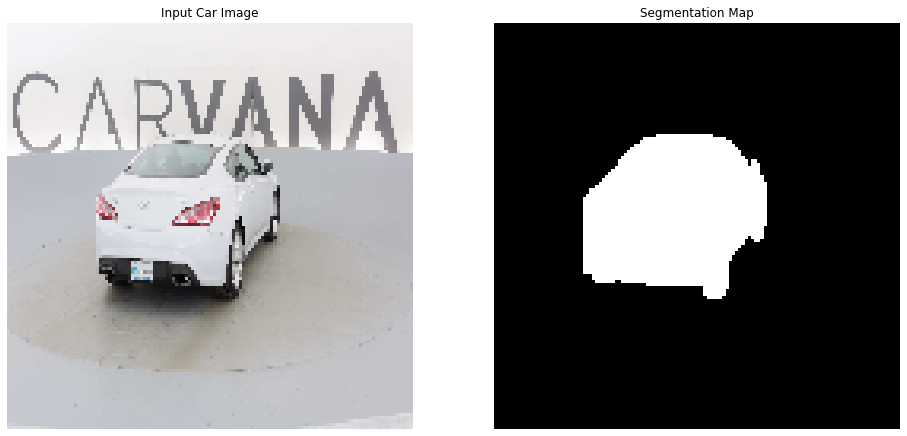

In [386]:
input_shape = (128, 128, 3)
key_id, row = next(df_train.sample(1).iterrows())
img1, mask1 = display_train_mask(row, input_shape)
print(img1.shape, img1.max(), img1.mean())
print(mask1.shape, mask1.max(), mask1.mean())

In [387]:
# Rotate, Shear, Horizontal Flip, Vertical Flip, Zoom
def flip(img, flip):
    
    input_shape = img.shape
    flipped_img = cv2.flip(img, -1)
    return flipped_img.reshape(input_shape)

def shear(img, shear):
        
    sheared_img = tf.keras.preprocessing.image.apply_affine_transform(img, shear=shear, 
                                                                      col_axis=1, 
                                                                      channel_axis=2, 
                                                                      fill_mode='nearest', 
                                                                      cval=0.0, order=1)
    return sheared_img

def rotate(img, theta):
            
    rotate_img = tf.keras.preprocessing.image.apply_affine_transform(img, theta=theta,
                                                                     col_axis=1, 
                                                                     channel_axis=2, 
                                                                     fill_mode='nearest', 
                                                                     cval=0.0, order=1)
    return rotate_img
    
def zoom(img, args):

    scale, shiftx, shifty = args
    zoomed_img = tf.keras.preprocessing.image.apply_affine_transform(img, 
                                                                     tx=shiftx, 
                                                                     ty=shifty, 
                                                                     zx=scale, 
                                                                     zy=scale)
    return zoomed_img

def channel_shift(img, arg=None):
    
    if img.shape[-1] == 1:
        return img
    channel_img = tf.keras.preprocessing.image.random_channel_shift(img, 0.5)
    return channel_img

## AUGMENTATIONS PLOTS

(128, 128, 3)
(128, 128, 1)


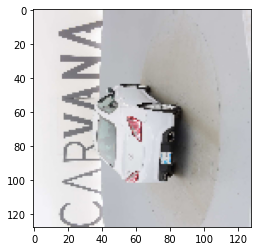

In [388]:
print(rotate(img1, -90).shape)
print(rotate(mask1, -90).shape)
plt.imshow(rotate(img1, -90))

(128, 128, 3)
(128, 128, 1)


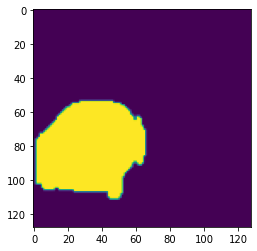

In [406]:
print(zoom(img1, (0.75, -300, 300)).shape)
print(zoom(mask1, (0.75, -300, 300)).shape)
plt.imshow(zoom(mask1, (0.9, -20, 20)))

(128, 128, 3)
(128, 128, 1)


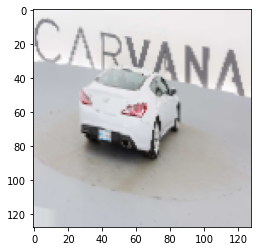

In [402]:
print(shear(img1, -10).shape)
print(shear(mask1, -10).shape)
plt.imshow(shear(img1, 10))

(128, 128, 3)
(128, 128, 1)


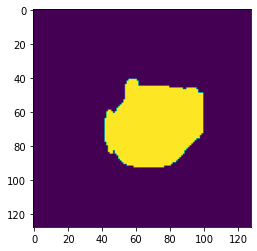

In [397]:
print(flip(img1, 1).shape)
print(flip(mask1, 1).shape)
plt.imshow(flip(mask1, 1))

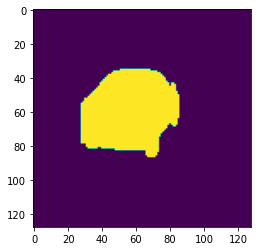

In [398]:
plt.imshow(channel_shift(mask1))

# DATAGENERATOR

In [407]:
class DataGenerator(Sequence):

    def __init__(self, df, img_height=400, img_width = 600, batch_size=16, shuffle=True, augment=True):
      
        'Initialization'
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.df = df
        self.list_IDs = df.index.to_list()
        self.augment = augment
        self.input_shape = [img_height, img_width, 3]
        self.on_epoch_end()

    def __len__(self):
        
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
                
        'Generate one batch of data'
        # Generate indexes of the batch
        if (index + 1) * self.batch_size > len(self.list_IDs):
            indexes = self.indexes[index * self.batch_size:]
        else:
            indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        file_batch = [self.list_IDs[k] for k in indexes]
        
        # Generate data
        images, masks = [], []
        
        for image_id in file_batch:
            
            img_path, mask_path = self.df.loc[image_id, ['path', 'mask_path']]
            
            # Load Image and Normalize
            img = img_to_array(load_img(row['path'], target_size=self.input_shape))/255
            images.append(img)
            
            # Load Mask
            mask = img_to_array(load_img(row['mask_path'], target_size=self.input_shape[:-1], color_mode = 'grayscale')).reshape(self.input_shape[:-1] + [1])/255
            masks.append(mask)

            # Data Augmentation
            if self.augment == True:
                new_imgs, new_masks = self.data_augment(img, mask)
            
                images = images + new_imgs
                masks = masks + new_masks

        images = np.array(images)
        masks = np.array(masks)

        return images, masks

    def data_augment(self, img, mask):

        'Perform 2 random data augmentations on the image and mask'

        theta = random.uniform(-90, 90)
        scale = (np.random.uniform(0.9, 1.3), np.random.randint(-20, 20), np.random.randint(-20, 20)) # reduced to 20 from 300 bc our image input is 128by128
        shear_val = np.random.uniform(-10, 10)
        flip_val =  random.choice([-1, 1])

        aug_1, aug_2 = random.sample([(rotate,theta), (shear,shear_val), (flip,flip_val), (zoom,scale), (channel_shift, None)], 2)
        new_imgs = [aug_1[0](img, aug_1[1]), aug_2[0](img, aug_2[1])]
        new_masks = [aug_1[0](mask, aug_1[1]), aug_2[0](mask, aug_2[1])]
        return new_imgs, new_masks
    
    def on_epoch_end(self):
        
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [89]:
def get_train_val(df, aug=True):
    
    unique_cars = df.car_id.unique()
    np.random.shuffle(unique_cars)
    
    if aug == True:
        split = 0.55
        
    else:
        split = 0.8
    
    frac = int(len(unique_cars)*split)
    train_cars = unique_cars[:frac]
    val_cars = unique_cars[frac:]
    
    X_train = df[df.car_id.isin(train_cars)]
    X_val = df[df.car_id.isin(val_cars)]
    
    return X_train, X_val

In [369]:
X_train_aug, X_val_aug = get_train_val(df_train)
X_train, X_val = get_train_val(df_train, False)

In [1499]:
# print(X_val.car_id.unique())
# print(X_train.car_id.unique())

In [1500]:
# print(X_val_aug.car_id.unique())
# print(X_train_aug.car_id.unique())

# MODELS

## MODEL METRICS

In [1501]:
def dice_coef(y_true, y_pred):
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    #intersection = K.sum(y_true_f * y_pred_f)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
    #score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    #return score

def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

### CALLBACKS

In [443]:
EarlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=4, mode='max', restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super(DisplayCallback, self).__init__()
    
    
    def on_epoch_begin(self, epoch, logs=None):
        
        if (epoch + 1) % 3 == 0 or epoch == 0:
            
            pred_mask = self.model.predict(img1.reshape( (1,)+(img1.shape) )) # Make shape into (1, height, width, 1)
            pred_mask = pred_mask.reshape(pred_mask.shape[1:])
            
            test_pred_mask = self.model.predict(test_img_for_epoch_viz.reshape( (1,)+(test_img_for_epoch_viz.shape) )) # Make shape into (1, height, width, 1)
            test_pred_mask = test_pred_mask.reshape(test_pred_mask.shape[1:])            

            plt.figure(figsize=(15, 15))
            title = ['Input Image', 'True Mask', 'Predicted Mask', 'Testing Image']
            display_list = [img1, mask1, pred_mask, test_pred_mask]
            for i in range(len(display_list)):
                plt.subplot(1, len(display_list), i+1)
                plt.title(title[i])
                plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
                plt.axis('off')
            plt.show()

## Original UNET 128

In [375]:
def get_unet_128(input_shape=(128, 128, 3), num_classes=1):
    
    assert input_shape == (128, 128, 3), 'Input shape should be (128, 128, 3)'
    
    inputs = Input(shape=input_shape)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = tf.keras.Model(inputs=inputs, outputs=classify)
    return model

    #model.compile(optimizer=RMSprop(learning_rate=0.0001), loss=bce_dice_loss, metrics=[dice_coef])

    return model

## MobileNetV2 + Unet

In [414]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels, input_shape=[256, 256, 3]):
    
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## My new Model

In [52]:
def downsample_block(filters, x):
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding="same")(x)
    return x
        
def downsample_bottleneck_block(filters, layer):
    
    layer = Conv2D(filters, (3, 3), padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)

    x = Conv2D(filters*2, (3, 3), padding='same')(layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = tf.keras.layers.Add()([layer, x])
    x = MaxPooling2D(3, strides=2, padding="same")(x)
    return x    
    

def upsample_bottleneck_block_1(filters, layer):

    x = Conv2D(filters/2, (3, 3), padding='same')(layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters/2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = tf.keras.layers.Add()([x, layer])
    
    x = UpSampling2D((2, 2), interpolation='bilinear')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x    
    
    
def upsample_bottleneck_block(filters, layer):

    x = Conv2D(filters, (3, 3), padding='same')(layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = tf.keras.layers.Add()([x, layer])
    
    x = UpSampling2D((2, 2), interpolation='bilinear')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x 
    
    
def transpose_block(filters, x):

    x = Conv2DTranspose(filters, (3, 3), strides=(2,2), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def transpose_bottleneck_block_1(filters, layer):

    x = Conv2D(filters/2, (3, 3), padding='same')(layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters/2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = tf.keras.layers.Add()([x, layer])
    
    x = Conv2DTranspose(filters, (3, 3), strides=(2,2), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def transpose_bottleneck_block(filters, layer):

    x = Conv2D(filters, (3, 3), padding='same')(layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = tf.keras.layers.Add()([x, layer])
    
    x = Conv2DTranspose(filters, (3, 3), strides=(2,2), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


In [417]:
tf.keras.backend.clear_session()

def make_myModel(input_shape = (256, 256, 3)):
    
    inputs = Input(shape=input_shape)

    x = downsample_bottleneck_block(64, inputs) # Returns 128x128x64
    x1 = downsample_bottleneck_block(32, x) # Returns 64x64x32
    x2 = downsample_bottleneck_block(16, x1) # Returns 32x32x16

    x3 = transpose_bottleneck_block_1(32, x2) # Returns 64x64x32 #upsample_bottleneck_block_1 32
    x_concat = tf.keras.layers.Concatenate()([x3, x1])
    x4 = transpose_bottleneck_block(64, x_concat) # Returns 128x128x64 #upsample_bottleneck_block 48
    x_concat2 = tf.keras.layers.Concatenate()([x4, x])
    x5 = transpose_bottleneck_block(128, x_concat2) # Returns 256x256x128 #upsample_bottleneck_block 112

    classify = Conv2DTranspose(1, (2, 2), padding="same",  activation='sigmoid')(x5)

    test_model = tf.keras.Model(inputs=inputs, outputs=classify)
    test_model.compile(optimizer='adam', loss = dice_loss, metrics=[dice_coef,'binary_accuracy'])
    
    return test_model

# TRAIN MODEL

In [447]:
tf.keras.backend.clear_session()

In [412]:
img_height = 128
img_width = 128
input_shape = [img_height, img_width, 3]

In [446]:
train_generator = DataGenerator(df=X_train, img_height=img_height, img_width=img_width, batch_size=6, shuffle=True, augment=True)
val_generator = DataGenerator(df=X_val, img_height=img_height, img_width=img_width, batch_size=6, shuffle=True, augment=False)

In [439]:
test_img_for_epoch_viz = img_to_array(load_img(r'D:\Fall2021_Temp\Elec 478\Project\test\test\046ebf665b81_07.jpg', target_size=input_shape))/255

## UNET 128

In [155]:
uNet = get_unet_128()
uNet.compile(optimizer=RMSprop(learning_rate=0.0001), loss=dice_coef_loss2, metrics=[dice_coef])

In [1502]:
# uNet.summary()

In [1503]:
# plot_model(uNet)

In [164]:
#history = uNet.fit(train_generator, epochs=35, validation_data=val_generator, callbacks=[DisplayCallback(), EarlyStop_callback])

## MobileNetV2 + Unet

In [399]:
unet2 = unet_model(1)

unet2.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

In [1504]:
# unet2.summary()

In [1505]:
# plot_model(unet2)

Epoch 1/100


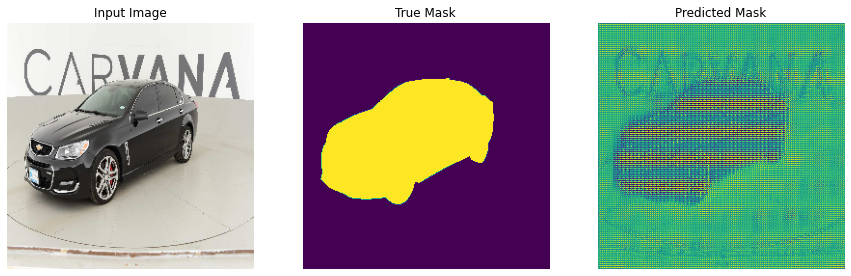

349/349 [==============================] - 253s 713ms/step - loss: 0.0060 - dice_coef: 0.9940 - binary_accuracy: 0.9843 - val_loss: 8.9985e-04 - val_dice_coef: 0.9991 - val_binary_accuracy: 0.9991
Epoch 2/100
349/349 [==============================] - 250s 715ms/step - loss: 5.0632e-04 - dice_coef: 0.9995 - binary_accuracy: 0.9947 - val_loss: 9.3772e-05 - val_dice_coef: 0.9999 - val_binary_accuracy: 1.0000
Epoch 3/100


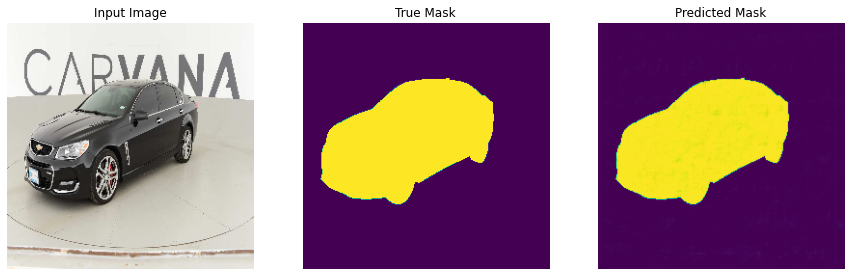

349/349 [==============================] - 254s 728ms/step - loss: 3.3597e-04 - dice_coef: 0.9997 - binary_accuracy: 0.9949 - val_loss: 3.3104e-05 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
349/349 [==============================] - 255s 730ms/step - loss: 2.7936e-04 - dice_coef: 0.9997 - binary_accuracy: 0.9948 - val_loss: 2.1903e-05 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
349/349 [==============================] - 253s 724ms/step - loss: 2.3537e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9949 - val_loss: 1.6454e-05 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100


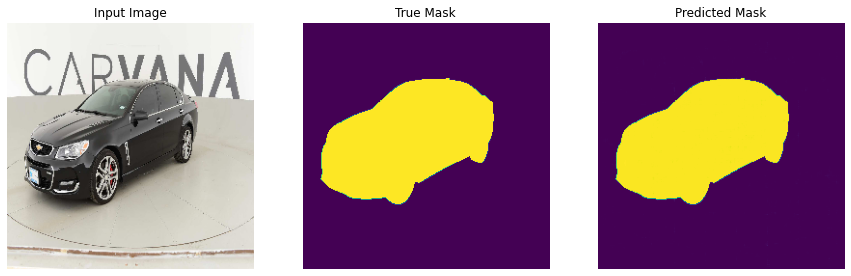

349/349 [==============================] - 258s 737ms/step - loss: 2.1874e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9949 - val_loss: 1.2372e-05 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/100
349/349 [==============================] - 251s 719ms/step - loss: 1.9778e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9949 - val_loss: 8.5152e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
349/349 [==============================] - 248s 711ms/step - loss: 1.8519e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9950 - val_loss: 1.2429e-05 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100


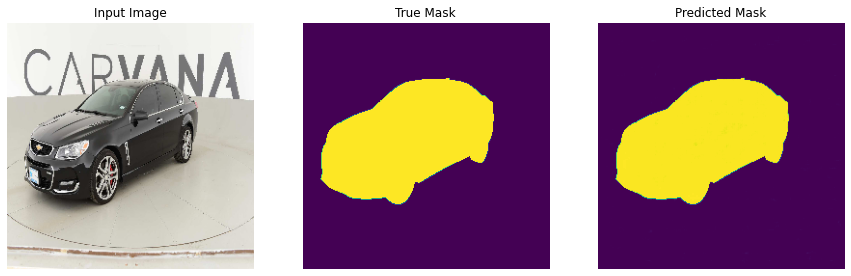

349/349 [==============================] - 246s 704ms/step - loss: 1.7820e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9949 - val_loss: 5.7613e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/100
349/349 [==============================] - 248s 711ms/step - loss: 1.6997e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9949 - val_loss: 7.9003e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
349/349 [==============================] - 255s 731ms/step - loss: 1.6761e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9950 - val_loss: 4.2014e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100


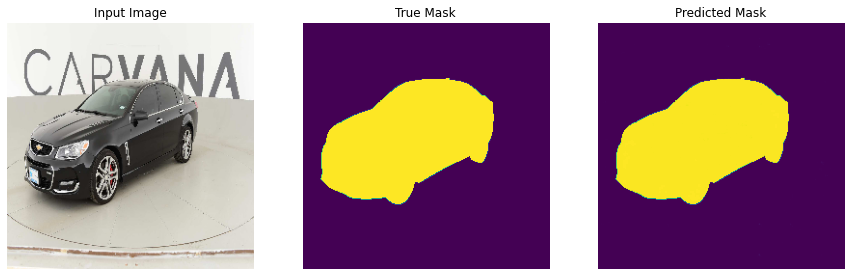

349/349 [==============================] - 246s 705ms/step - loss: 1.6390e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9949 - val_loss: 5.1312e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 13/100
349/349 [==============================] - 245s 701ms/step - loss: 1.5824e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9949 - val_loss: 2.6080e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 14/100
349/349 [==============================] - 246s 704ms/step - loss: 1.5262e-04 - dice_coef: 0.9998 - binary_accuracy: 0.9950 - val_loss: 2.6889e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 15/100


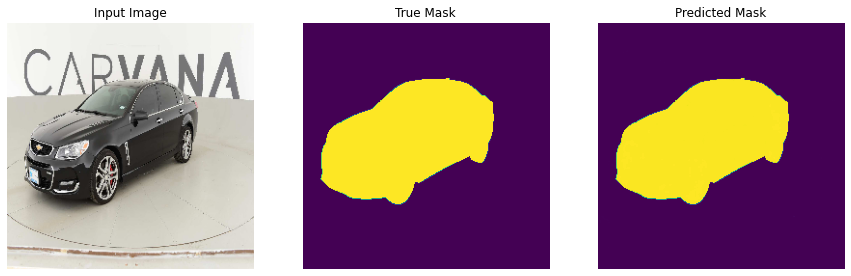

349/349 [==============================] - 246s 704ms/step - loss: 1.4835e-04 - dice_coef: 0.9999 - binary_accuracy: 0.9950 - val_loss: 3.2974e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 16/100
349/349 [==============================] - 245s 703ms/step - loss: 1.4601e-04 - dice_coef: 0.9999 - binary_accuracy: 0.9949 - val_loss: 2.4064e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 17/100
349/349 [==============================] - 244s 700ms/step - loss: 1.4168e-04 - dice_coef: 0.9999 - binary_accuracy: 0.9950 - val_loss: 2.2735e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000


In [400]:
history = unet2.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[DisplayCallback(), EarlyStop_callback])

(256, 256, 3)


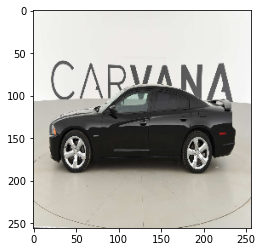

(1, 256, 256, 1)


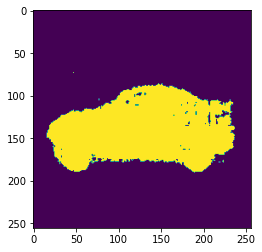

In [1509]:
print(test_img_256.shape)
plt.figure()
plt.imshow(test_img_256)
plt.show()

prediction = unet2_reconstructed.predict(test_img_256.reshape(1, 256, 256, 3))
print(prediction.shape)
plt.figure()
plt.imshow(tf.keras.preprocessing.image.array_to_img(np.round(prediction[0])))
#plt.imshow(prediction[0])
plt.show()

In [578]:
#unet2.save(os.path.join(base_path, "unet2Model"))

## MY MODEL

In [1511]:
test_model = make_myModel(input_shape=input_shape)
# test_model.summary() # Last layer should be (None, 256, 256, 1)

In [1510]:
# plot_model(test_model)

Epoch 1/20


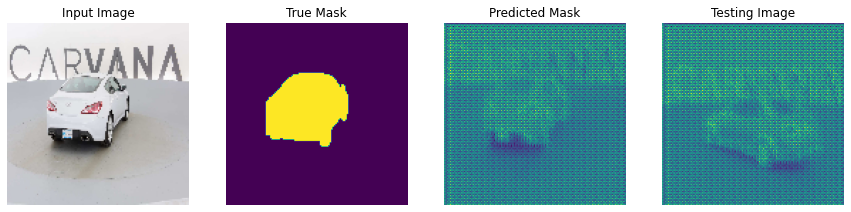

677/677 [==============================] - 235s 342ms/step - loss: 0.0024 - dice_coef: 0.9976 - binary_accuracy: 0.9900 - val_loss: 0.0026 - val_dice_coef: 0.9974 - val_binary_accuracy: 0.9911
Epoch 2/20
677/677 [==============================] - 231s 341ms/step - loss: 1.1941e-04 - dice_coef: 0.9999 - binary_accuracy: 0.9946 - val_loss: 4.8153e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/20


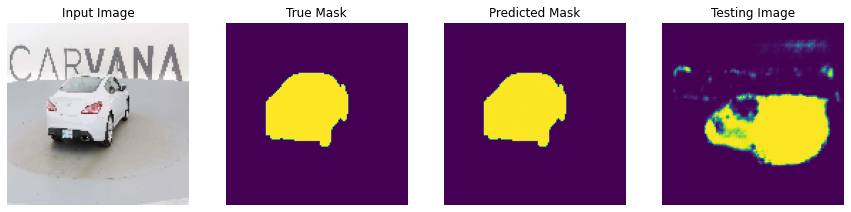

677/677 [==============================] - 233s 344ms/step - loss: 6.6627e-05 - dice_coef: 0.9999 - binary_accuracy: 0.9947 - val_loss: 2.7759e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/20
677/677 [==============================] - 233s 344ms/step - loss: 5.1322e-05 - dice_coef: 0.9999 - binary_accuracy: 0.9947 - val_loss: 3.4947e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/20
677/677 [==============================] - 234s 345ms/step - loss: 4.3876e-05 - dice_coef: 1.0000 - binary_accuracy: 0.9946 - val_loss: 9.8434e-07 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/20


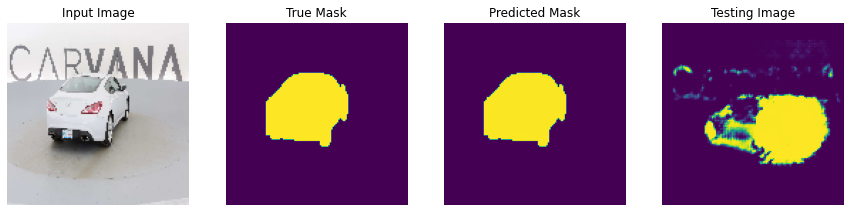

677/677 [==============================] - 234s 345ms/step - loss: 3.2610e-05 - dice_coef: 1.0000 - binary_accuracy: 0.9947 - val_loss: 1.1366e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/20
677/677 [==============================] - 234s 345ms/step - loss: 2.7639e-05 - dice_coef: 1.0000 - binary_accuracy: 0.9947 - val_loss: 3.4938e-07 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/20
677/677 [==============================] - 234s 346ms/step - loss: 2.6090e-05 - dice_coef: 1.0000 - binary_accuracy: 0.9946 - val_loss: 2.4811e-07 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/20


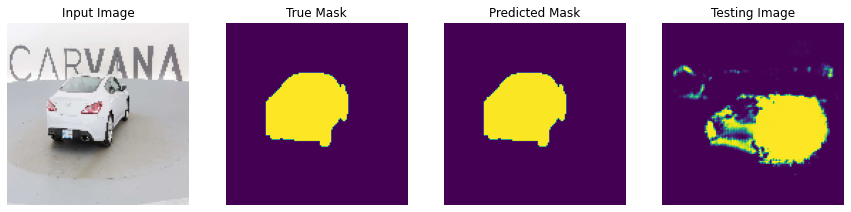

677/677 [==============================] - 233s 344ms/step - loss: 2.0669e-05 - dice_coef: 1.0000 - binary_accuracy: 0.9946 - val_loss: 1.6839e-07 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/20
677/677 [==============================] - 233s 344ms/step - loss: 1.7760e-05 - dice_coef: 1.0000 - binary_accuracy: 0.9946 - val_loss: 4.3770e-07 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/20
677/677 [==============================] - 236s 349ms/step - loss: 1.6956e-05 - dice_coef: 1.0000 - binary_accuracy: 0.9947 - val_loss: 6.6267e-06 - val_dice_coef: 1.0000 - val_binary_accuracy: 1.0000


In [449]:
history = test_model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[DisplayCallback(), EarlyStop_callback])

In [454]:
# test_model.save(os.path.join(base_path, "myModel_2"))

# EVALUATION

In [1513]:
######### UNCOMMENT THE FOLLOWING TO RECONSTRUCT THE MODEL #########

# unet2_reconstructed = keras.models.load_model(os.path.join(base_path, "unet2Model"), compile=False)
# unet2_reconstructed.compile(optimizer='adam', loss = dice_loss, metrics=[dice_coef,'binary_accuracy'])

In [1514]:
######### UNCOMMENT THE FOLLOWING TO RECONSTRUCT THE MODEL #########

# myModel1_reconstructed = keras.models.load_model(os.path.join(base_path, "test_model_1"), compile=False)
# myModel1_reconstructed.compile(optimizer='adam', loss = dice_loss, metrics=[dice_coef,'binary_accuracy'])

In [1524]:
######### UNCOMMENT THE FOLLOWING TO RECONSTRUCT THE MODEL #########

# test_model = keras.models.load_model(os.path.join(base_path, "myModel_2"), compile=False)
# test_model.compile(optimizer='adam', loss = dice_loss, metrics=[dice_coef,'binary_accuracy'])

In [1573]:
# 000f19f6e7d4_01, 00d3de919651_03, 046ebf665b81_14, 046ebf665b81_07, a872c6d97af2_16, 863aab34cc76_08, 00ad56bf7ee6_03, 9b5ce8289162_10, 34bbde9ad3c7_10, 32b9c4c53fd5_09, 8813e62dc404_06, bb8bc96193fb_05, 6999d81088d5_08
test_id = '6999d81088d5_08'

test_img_256 = img_to_array(load_img(r'D:\Fall2021_Temp\Elec 478\Project\test\test\{}.jpg'.format(test_id), target_size=(256, 256, 3)))/255
test_img_128 = img_to_array(load_img(r'D:\Fall2021_Temp\Elec 478\Project\test\test\{}.jpg'.format(test_id), target_size=(128, 128, 3)))/255

My Model Prediction
(128, 128, 3)


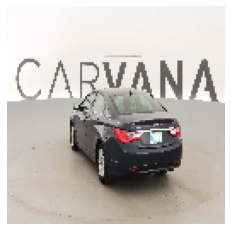

(1, 128, 128, 1)


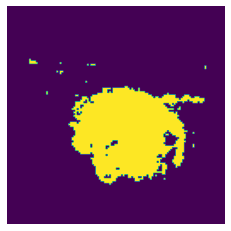

In [1574]:
print('My Model Prediction')
print(test_img_128.shape)
plt.figure()
plt.imshow(test_img_128)
plt.axis('off')
plt.show()

prediction_2 = test_model.predict(test_img_128.reshape(1, 128, 128, 3))
print(prediction_2.shape)
plt.figure()
plt.imshow(tf.keras.preprocessing.image.array_to_img(np.round(prediction_2[0])))
plt.axis('off')
#plt.imshow(prediction[0])
plt.show()

My Model That did not use data augmentation Prediction
(256, 256, 3)


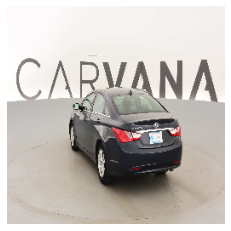

(1, 256, 256, 1)


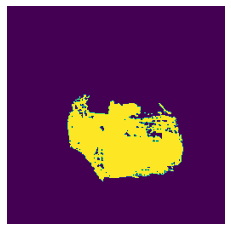

In [1575]:
print('My Model That did not use data augmentation Prediction')
print(test_img_256.shape)
plt.figure()
plt.imshow(test_img_256)
plt.axis('off')
plt.show()

prediction_3 = myModel1_reconstructed.predict(test_img_256.reshape(1, 256, 256, 3))
print(prediction_3.shape)
plt.figure()

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
prediction_3_norm = NormalizeData(prediction_3)

plt.imshow(tf.keras.preprocessing.image.array_to_img(np.round(prediction_3_norm[0])))
plt.axis('off')
plt.show()

Semi Pretrained UNet Prediction
(1, 256, 256, 1)


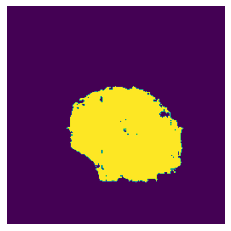

In [1576]:
print('Semi Pretrained UNet Prediction')
prediction_from_reconstructed = unet2_reconstructed.predict(test_img_256.reshape(1, 256, 256, 3))
print(prediction_from_reconstructed.shape)
plt.axis('off')
plt.imshow(tf.keras.preprocessing.image.array_to_img(np.round(prediction_from_reconstructed[0])))

In [1577]:
prob = tf.image.resize(prediction_2, (256, 256))
prob = np.array(prob)
#ensembled_img = 0.5*(prediction_from_reconstructed) + 0.5*(prob)

ensembled_img = 0.4*(prediction_from_reconstructed) + 0.3*(prob) + 0.3*(prediction_3_norm) # 3333333
ensembled_img = np.where(ensembled_img > 0.35, 1, 0)

Ensembled Image


(-0.5, 255.5, 255.5, -0.5)

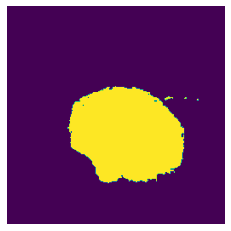

In [1578]:
print('Ensembled Image')
plt.imshow(tf.keras.preprocessing.image.array_to_img(ensembled_img[0]))
plt.axis('off')

(-0.5, 1917.5, 1279.5, -0.5)

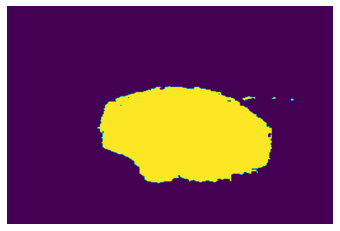

In [1579]:
j = tf.image.resize(ensembled_img[0], (orig_height, orig_width))
plt.imshow(np.round(j))
plt.axis('off')

(-0.5, 1917.5, 1279.5, -0.5)

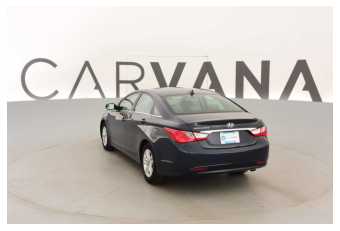

In [1580]:
test_img = img_to_array(load_img(r'D:\Fall2021_Temp\Elec 478\Project\test\test\{}.jpg'.format(test_id), target_size=(orig_height, orig_width, 3)))/255
plt.imshow(test_img)
plt.axis('off')

# Create Submission

In [1472]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [1359]:
df_test = pd.read_csv(r'D:\Fall2021_Temp\Elec 478\Project\sample_submission.csv\sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

In [1366]:
orig_width = 1918
orig_height = 1280
batch_size = 8

In [1361]:
names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))

In [1471]:
def get_predictions(batch_128, batch_256):
    
    prediction_2 = test_model.predict(batch_128)
    
    prediction_3 = myModel1_reconstructed.predict(batch_256)
    
    prediction_from_reconstructed = unet2_reconstructed.predict(batch_256)
    
    return prediction_2, prediction_3, prediction_from_reconstructed

In [1474]:
rles = []

print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), batch_size))
for start in tqdm(range(0, len(ids_test), batch_size)):
    
    x_batch_256 = []
    x_batch_128 = []
    
    end = min(start + batch_size, len(ids_test))
    ids_test_batch = ids_test[start:end]
    
    for id in ids_test_batch.values:
        
        img = img_to_array(load_img(r'D:\Fall2021_Temp\Elec 478\Project\test\test\{}.jpg'.format(id), target_size=(256, 256, 3)))/255
        x_batch_256.append(img)
        
        img = img_to_array(load_img(r'D:\Fall2021_Temp\Elec 478\Project\test\test\{}.jpg'.format(id), target_size=(128, 128, 3)))/255
        x_batch_128.append(img)        
    
    x_batch_256 = np.array(x_batch_256, np.float32)
    x_batch_128 = np.array(x_batch_128, np.float32)
    
    #preds = unet2.predict(x_batch_256)
    predictions_2, predictions_3, predictions_from_reconstructed = get_predictions(x_batch_128, x_batch_256)
    
    for i in list(range(len(predictions_2))):

        prediction_2 = predictions_2[i]
        prob = tf.image.resize(prediction_2, (256, 256)) # I made an oopsie and set the input shape to 128x128, can just resize tho
        prob = np.array(prob)        
        
        prediction_3 = predictions_3[i]
        def NormalizeData(data): # Made another oopsie and forgot to add a sigmoid function on the last layer, didnt realize until much later
            return (data - np.min(data)) / (np.max(data) - np.min(data))
        prediction_3_norm = NormalizeData(prediction_3)

        prediction_from_reconstructed = predictions_from_reconstructed[i]

        
        ensembled_img = 0.5*(prediction_from_reconstructed) + 0.3*(prob) + 0.2*(prediction_3_norm)
        ensembled_img = np.where(ensembled_img > 0.35, 1, 0)
        ensembled_img = tf.image.resize(ensembled_img, (orig_height, orig_width))
        

        mask = np.array(ensembled_img) > 0.5
        rle_result = rle_encode(mask)
        rles.append(rle_result)

Predicting on 100064 samples with batch_size = 8...


100%|██████████| 12508/12508 [3:16:54<00:00,  1.06it/s]  


In [1477]:
# print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})

In [1479]:
df.to_csv(r'D:\Fall2021_Temp\Elec 478\Project\submission_ensemble.csv', index=False)

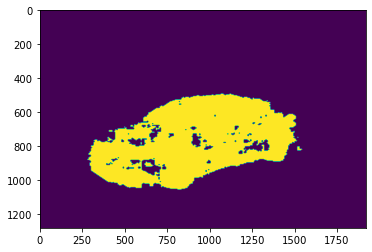

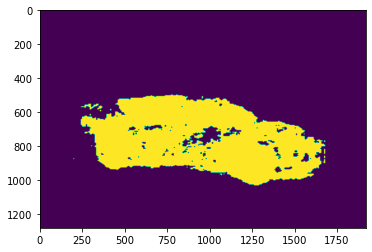

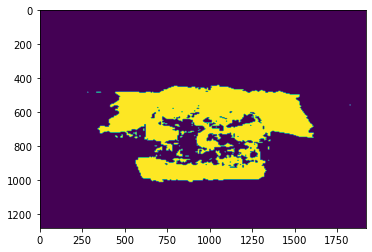

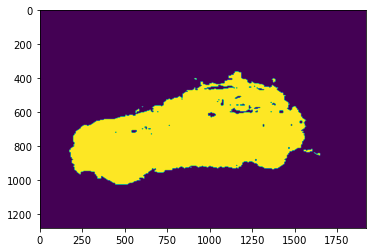

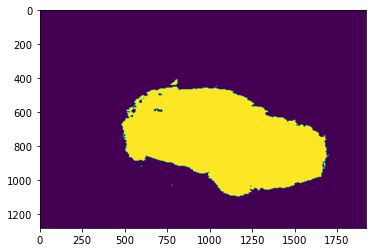

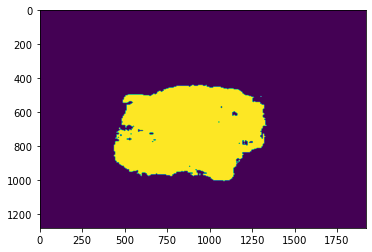

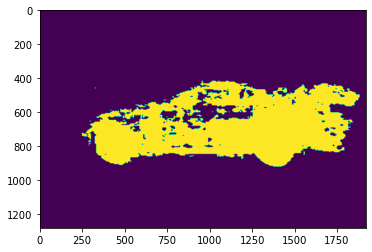

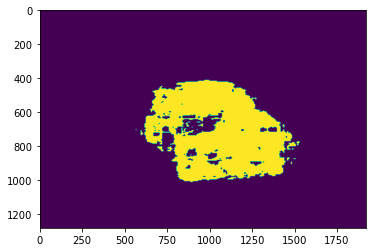

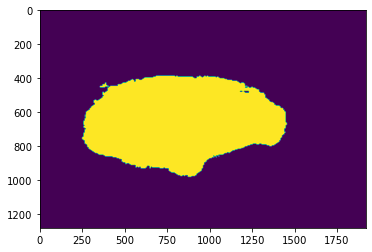

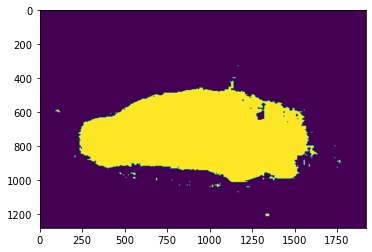

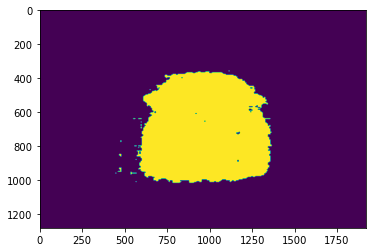

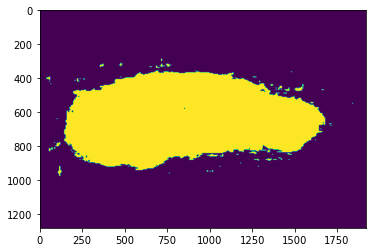

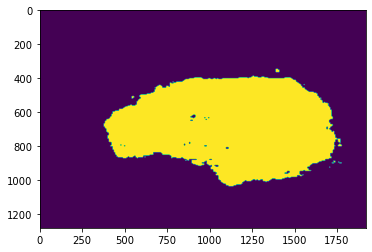

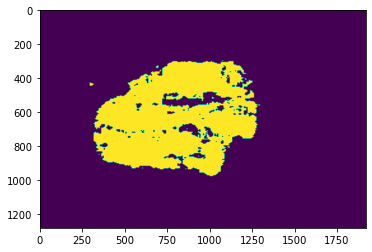

In [1520]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

for i in list(range(50, 200, 11)):

    name, rle_mask = df.values[i]
    
    plt.figure()
    plt.imshow(rle_decode(rle_mask, (1280, 1918)))
    plt.show()